# **SINGLE AND 2 (MAYBE 3) QUBIT GATE OPERATIONS TEMPLATE**




In [16]:
#pip install qutip

In [17]:
#pip install pulser

In [18]:

import numpy as np
import matplotlib.pyplot as plt
import qutip
from itertools import product
from pulser import Pulse, Sequence, Register
from pulser.devices import Chadoq2
from pulser.simulation import Simulation
from pulser.waveforms import BlackmanWaveform,ConstantWaveform


# 1. State and sequence building functions

Registers

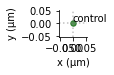

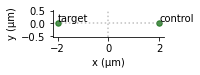

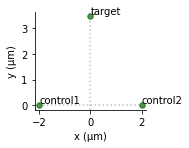

In [19]:
# Atom Register
q_dict = {"control":np.array([0,0.])}
single_qubit = Register(q_dict)
q_dict1 = {"target":np.array([-2,0.]),"control":np.array([2,0.])}
two_qubits = Register(q_dict1)
q_dict2 = {"target":np.array([0., 2*np.sqrt(3.001)]),"control1":np.array([-2,0.]),"control2":np.array([2,0.])}
qubit_triangle = Register(q_dict2)
single_qubit.draw()
two_qubits.draw()
qubit_triangle.draw()

 Pulses

In [20]:
duration = 300
pi_Y = Pulse.ConstantDetuning(BlackmanWaveform(duration, np.pi), 0., -np.pi/2)
halfpi_pulse = Pulse.ConstantDetuning(BlackmanWaveform(duration, np.pi/2), 0.,np.pi/2, post_phase_shift=np.pi)
pi_pulse = Pulse.ConstantDetuning(BlackmanWaveform(duration, np.pi), 0., 0)
twopi_pulse = Pulse.ConstantDetuning(BlackmanWaveform(duration, 2*np.pi), 0., 0)

State and sequence building functions

In [21]:
def build_state_from_id(s_id, basis_name):
    if len(s_id) not in {1,2,3}:
        raise ValueError("Not a valid state ID string")

    ids = {"single-digital":'hg', 'digital': 'gh', 'ground-rydberg': 'rg', 'all': 'rgh'}
    if basis_name not in ids:
        raise ValueError('Not a valid basis')

    pool = {''.join(x) for x in product(ids[basis_name], repeat=len(s_id))}
    if s_id not in pool:
        raise ValueError('Not a valid state id for the given basis.')

    ket = {op: qutip.basis(len(ids[basis_name]), i)
           for i, op in enumerate(ids[basis_name])}
    if len(s_id) == 3:
        return qutip.tensor([ket[x] for x in s_id])
    elif len(s_id) == 2:
        return qutip.tensor([ket[x] for x in s_id])
    elif(len(s_id) == 1 and s_id == 'h' ):
        return qutip.ket("1")
    else:
        return qutip.ket("0")



def preparation_sequence(state_id, reg, basis):
    global seq

    if not set(state_id) <= {'g','h','r'} or len(state_id) != len(reg.qubits):
        raise ValueError('Not a valid state ID')
    if len(reg.qubits) == 1:
        seq_dict = {'0':'control'}
    elif len(reg.qubits) == 2:
        seq_dict = {'1':'control', '0':'target'}
    elif len(reg.qubits) == 3:
        seq_dict = {'2':'control2', '1':'control1', '0':'target'}

    seq = Sequence(reg, Chadoq2)
    if set(state_id) == {'g'}:
        print(f'Warning: {state_id} state does not require a preparation sequence.')
    elif basis == "single-digital":
        for k in range(len(reg.qubits)):
            if state_id[k] == 'h':
                if 'raman' not in seq.declared_channels:
                    seq.declare_channel('raman','raman_local', seq_dict[str(k)])
                else:
                    seq.target(seq_dict[str(k)],'raman')
                seq.add(pi_Y,'raman')
    elif basis == "digital":
        for k in range(len(reg.qubits)):
            if state_id[k] == 'h':
                if 'raman' not in seq.declared_channels:
                    seq.declare_channel('raman','raman_local', seq_dict[str(k)])
                else:
                    seq.target(seq_dict[str(k)],'raman')
                seq.add(pi_Y,'raman')
    elif basis == "ground-rydberg":
        for k in range(len(reg.qubits)):
            if state_id[k] == 'r':
                if 'ryd' not in seq.declared_channels:
                    seq.declare_channel('ryd','rydberg_local', seq_dict[str(k)])
                else:
                    seq.target(seq_dict[str(k)],'ryd')
                seq.add(pi_Y,'ryd')
    elif basis == "all":
        for k in range(len(reg.qubits)):
            if state_id[k] == 'h':
                if 'raman' not in seq.declared_channels:
                    seq.declare_channel('raman','raman_local', seq_dict[str(k)])
                else:
                    seq.target(seq_dict[str(k)],'raman')
                seq.add(pi_Y,'raman')
            elif state_id[k] == 'r':
                if 'ryd' not in seq.declared_channels:
                    seq.declare_channel('ryd','rydberg_local', seq_dict[str(k)])
                else:
                    seq.target(seq_dict[str(k)],'ryd')
                seq.add(pi_Y,'ryd')

    prep_state = build_state_from_id(state_id, basis) 

    return prep_state

    #########                         #########
    #########       Sequences         #########
    #########                         #########

def CZ_sequence(initial_id,reg,basis):
    
    # Prepare State
    prep_state = preparation_sequence(initial_id, reg,basis)
    prep_time = max((seq._last(ch).tf for ch in seq.declared_channels), default=0)

    # Declare Rydberg channel
    if 'ryd' not in seq.declared_channels:
        seq.declare_channel('ryd', 'rydberg_local', 'control')

    # Write CZ sequence:
    seq.add(pi_pulse, 'ryd', 'wait-for-all')  # Wait for state preparation to finish.
    seq.target('target', 'ryd')    # Changes to target qubit
    seq.add(twopi_pulse, 'ryd')
    seq.target('control', 'ryd')     # Changes back to control qubit
    seq.add(pi_pulse, 'ryd')

    return prep_state, prep_time

def CNOT_sequence(initial_id,reg,basis):
    
    # Prepare State
    prep_state = preparation_sequence(initial_id, reg,basis)
    prep_time = max((seq._last(ch).tf for ch in seq.declared_channels), default=0)

    # Declare Rydberg channel
    if 'raman' not in seq.declared_channels:
        seq.declare_channel('raman','raman_local', 'control')

    # the operations of the CNOT gate are:
    # > leaves the control qubit unchanged and performs a Pauli-X gate on the target qubit when the control qubit is in state high
    # > leaves the target qubit unchanged when the control qubit is in state ground

    if initial_id == 'hg' or 'hh':
        seq.target('target', 'raman')
        seq.add(pi_pulse, 'raman')
        

    # # Write CZ sequence:
    # seq.add(pi_pulse, 'ryd', 'wait-for-all')  # Wait for state preparation to finish.
    # seq.target('target', 'ryd')    # Changes to target qubit
    # seq.add(twopi_pulse, 'ryd')
    # seq.target('control', 'ryd')     # Changes back to control qubit
    # seq.add(pi_pulse, 'ryd')

    return prep_state, prep_time


def Hadamard_sequence(initial_id,reg, basis):

    # Prepare State
    prep_state = preparation_sequence(initial_id, reg, basis)
    prep_time = max((seq._last(ch).tf for ch in seq.declared_channels), default=0)

   
    if 'raman' not in seq.declared_channels:
      seq.declare_channel('raman','raman_local', 'control')
    # Write Hadamard sequence:
    seq.add(halfpi_pulse, 'raman', 'wait-for-all')  # Wait for state preparation to finish.
    
    return prep_state, prep_time

def X_sequence(initial_id,reg, basis):

    # Prepare State
    prep_state = preparation_sequence(initial_id, reg, basis)
    prep_time = max((seq._last(ch).tf for ch in seq.declared_channels), default=0)

   
    if 'raman' not in seq.declared_channels:
      seq.declare_channel('raman','raman_local', 'control')
    # Write X sequence:
    seq.add(pi_pulse, 'raman', 'wait-for-all')  # Wait for state preparation to finish.
    
    return prep_state, prep_time


# 2. Testing Preperation fucntions

In this section we will test the different implemented functions for coherency.

In [22]:
#This function builds the qutip qobject representing the desired vector state
build_state_from_id('gr','ground-rydberg')

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [1.]
 [0.]]

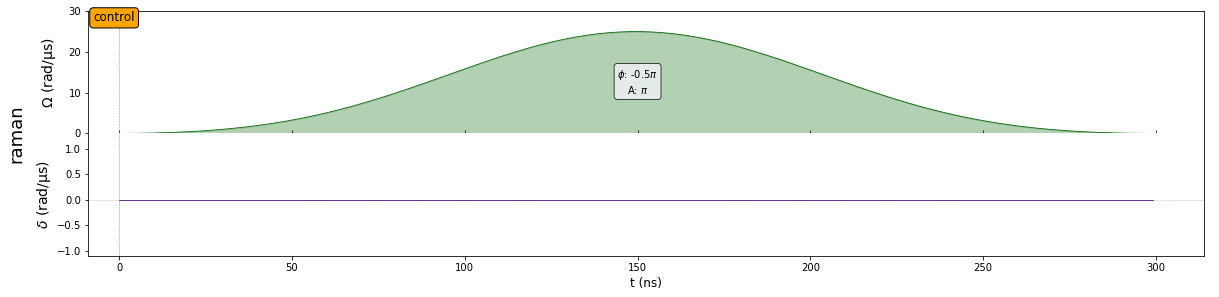

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.]
 [1.]]

In [23]:
#This function creates the sequence of  pulses required to achieve the preperation state
prep_state = preparation_sequence('h', single_qubit,"single-digital") #again make sure register has same number of qubits as the state 
seq.draw(draw_phase_area=True)
prep_state

# Testing Sequence functions

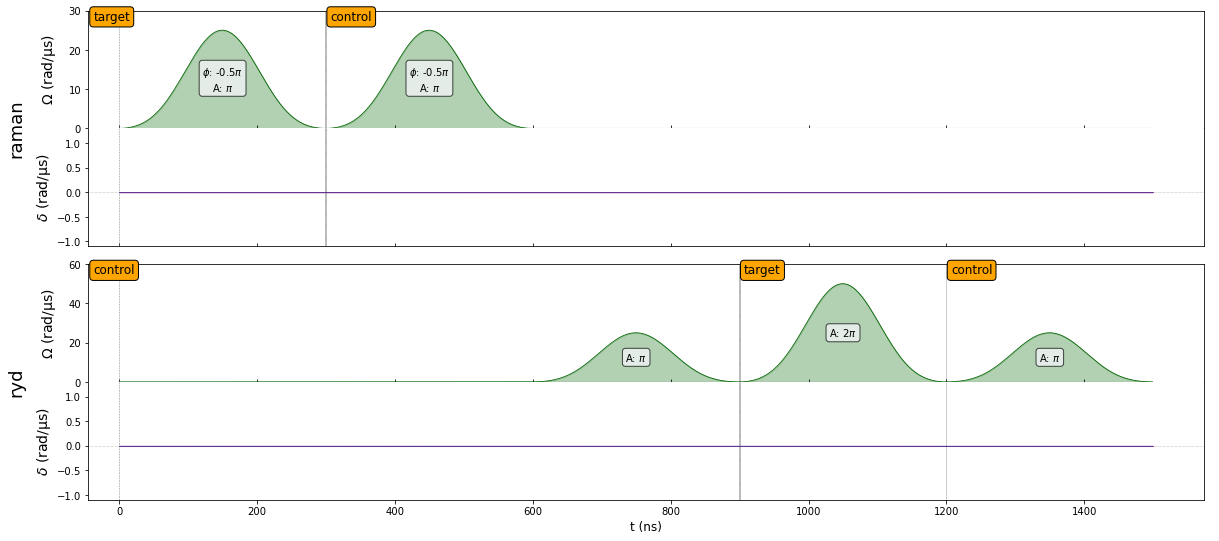

Prepared state: Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [1.]]
Preparation time: 600ns


In [24]:
##  CZ Pulse sequence
prep_state, prep_time = CZ_sequence('hh',two_qubits,'digital') # constructs seq, prep_state and prep_time
seq.draw(draw_phase_area=True)
print(f'Prepared state: {prep_state}')
print(f'Preparation time: {prep_time}ns')

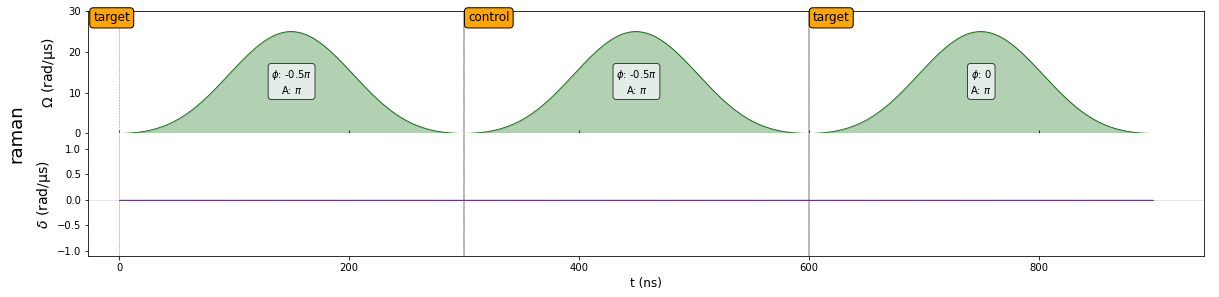

Prepared state: Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [1.]]
Preparation time: 600ns


In [25]:
##  CNOT Pulse sequence
prep_state, prep_time = CNOT_sequence('hh',two_qubits,'digital') # constructs seq, prep_state and prep_time
seq.draw(draw_phase_area=True)
print(f'Prepared state: {prep_state}')
print(f'Preparation time: {prep_time}ns')

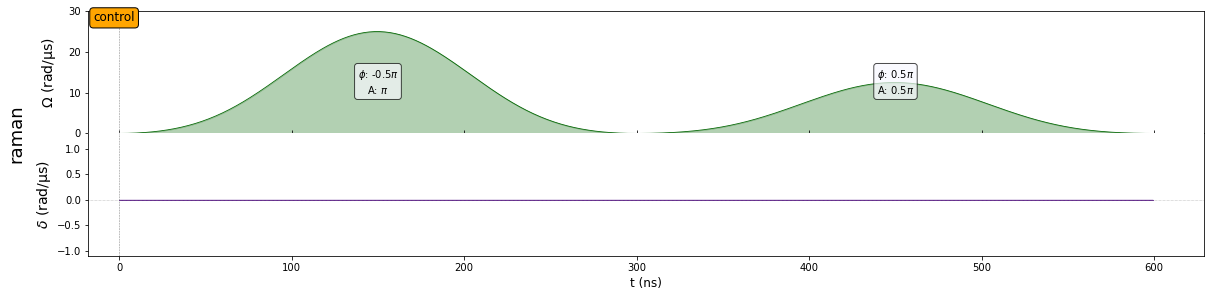

Prepared state: Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.]
 [1.]]
Preparation time: 300ns


In [26]:
##  Hadamard Pulse sequence
prep_state, prep_time = Hadamard_sequence('h',single_qubit,'single-digital') # constructs seq, prep_state and prep_time
seq.draw(draw_phase_area=True)
print(f'Prepared state: {prep_state}')
print(f'Preparation time: {prep_time}ns')

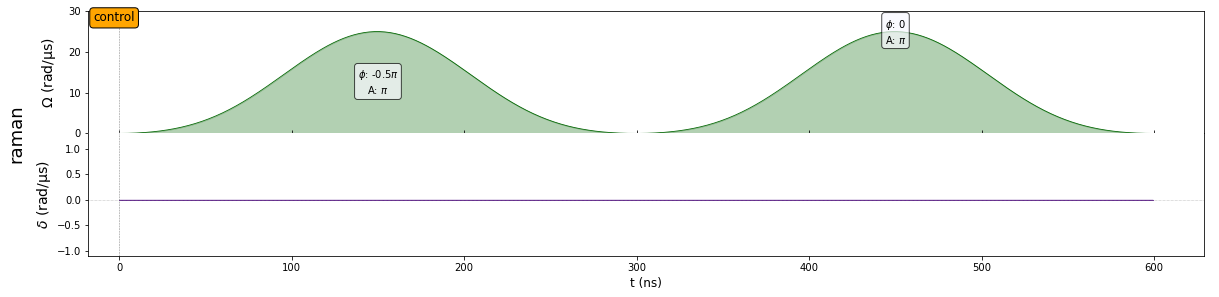

Prepared state: Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.]
 [1.]]
Preparation time: 300ns


In [27]:
##  X Pulse sequence
prep_state, prep_time = X_sequence('h',single_qubit,'single-digital') # constructs seq, prep_state and prep_time
seq.draw(draw_phase_area=True)
print(f'Prepared state: {prep_state}')
print(f'Preparation time: {prep_time}ns')

#4. Simulating the sequences

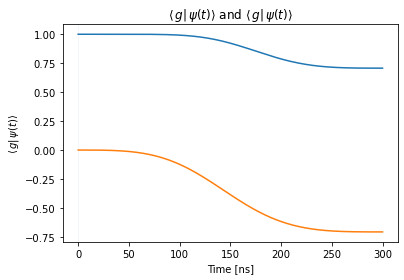

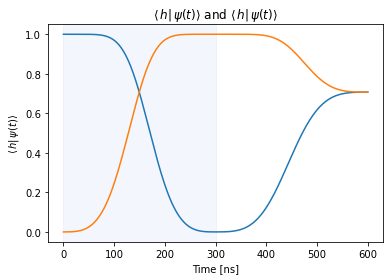

In [28]:
# Hadamard Gate Sequence 
for state_id in {'g','h'}:
    Hadamard = {}
    # Get Hadamard sequence
    prep_state, prep_time = Hadamard_sequence(state_id,single_qubit,"single-digital") # constructs seq, prep_state and prep_time

    # Construct Simulation instance
    simul = Simulation(seq)
    res = simul.run()


    data1=[st.overlap(qutip.ket('0')) for st in res.states]
    data2=[st.overlap(qutip.ket('1')) for st in res.states]
 
    final_st = res.states[-1]
    Hadamard[state_id] = final_st.overlap(prep_state)

    plt.figure()

    plt.plot(np.real(data1))
    plt.plot(np.real(data2))
    plt.xlabel(r"Time [ns]")
    plt.ylabel(fr'$ \langle\,{state_id} |\, \psi(t)\rangle$')
    plt.axvspan(0, prep_time, alpha=0.06, color='royalblue')
    plt.title(fr"$ \langle\,{state_id} |\, \psi(t)\rangle$ and $ \langle\,{state_id} |\, \psi(t)\rangle$")

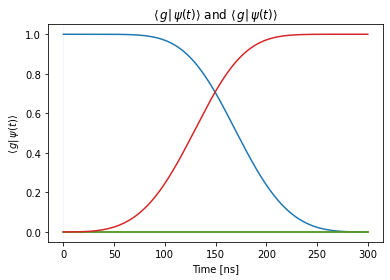

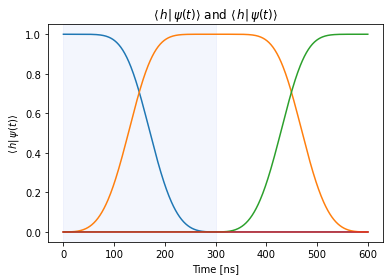

In [29]:
# X Gate Sequence 
for state_id in {'g','h'}:
    X = {}
    # Get Hadamard sequence
    prep_state, prep_time = X_sequence(state_id,single_qubit,"single-digital") # constructs seq, prep_state and prep_time

    # Construct Simulation instance
    simul = Simulation(seq)
    res = simul.run()


    data1=[st.overlap(qutip.ket('0')) for st in res.states]
    data2=[st.overlap(qutip.ket('1')) for st in res.states]
 
    final_st = res.states[-1]
    X[state_id] = final_st.overlap(prep_state)

    plt.figure()

    plt.plot(np.real(data1))
    plt.plot(np.real(data2))
    plt.plot(np.imag(data1))
    plt.plot(np.imag(data2))
    plt.legend
    plt.xlabel(r"Time [ns]")
    plt.ylabel(fr'$ \langle\,{state_id} |\, \psi(t)\rangle$')
    plt.axvspan(0, prep_time, alpha=0.06, color='royalblue')
    plt.title(fr"$ \langle\,{state_id} |\, \psi(t)\rangle$ and $ \langle\,{state_id} |\, \psi(t)\rangle$")

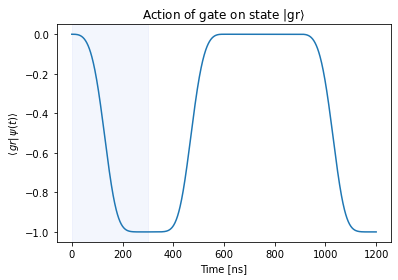

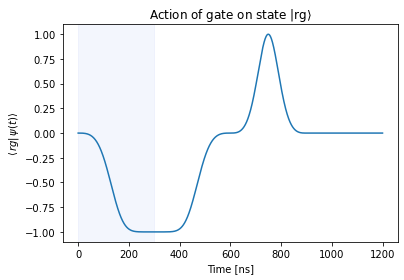

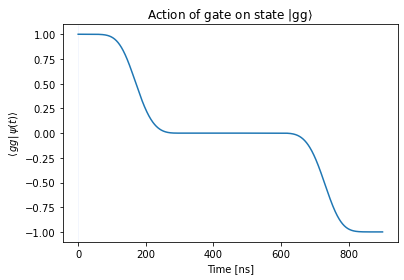

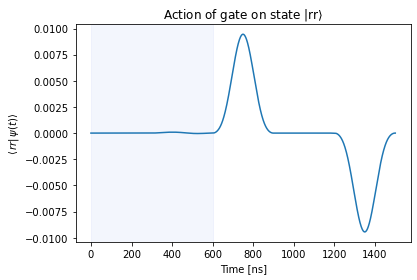

In [30]:
CZ = {}
for state_id in {'gg','rg','gr','rr'}:
    # Get CZ sequence
    prep_state, prep_time = CZ_sequence(state_id,two_qubits,'ground-rydberg') # constructs seq, prep_state and prep_time

    # Construct Simulation instance
    simul = Simulation(seq)
    res = simul.run()

    data=[st.overlap(prep_state) for st in res.states]

    final_st = res.states[-1]
    CZ[state_id] = final_st.overlap(prep_state)

    plt.figure()
    plt.plot(np.real(data))
    plt.xlabel(r"Time [ns]")
    plt.ylabel(fr'$ \langle\,{state_id} |\, \psi(t)\rangle$')
    plt.axvspan(0, prep_time, alpha=0.06, color='royalblue')
    plt.title(fr"Action of gate on state $|${state_id}$\rangle$")
    CZ

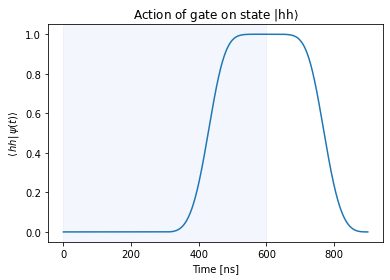

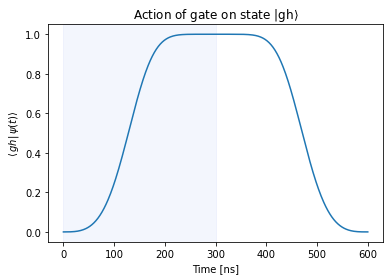

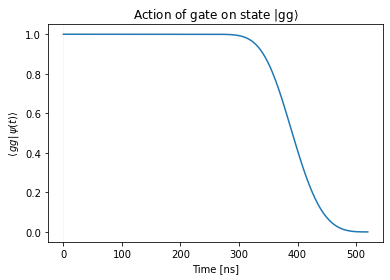

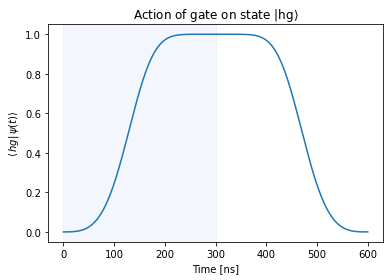

In [31]:
CNOT = {}
for state_id in {'gg','gh','hh','hg'}:
    # Get CNOT sequence
    prep_state, prep_time = CNOT_sequence(state_id,two_qubits,'digital') # constructs seq, prep_state and prep_time

    # Construct Simulation instance
    simul = Simulation(seq)
    res = simul.run()

    data=[st.overlap(prep_state) for st in res.states]

    final_st = res.states[-1]
    CNOT[state_id] = final_st.overlap(prep_state)

    plt.figure()
    plt.plot(np.real(data))
    plt.xlabel(r"Time [ns]")
    plt.ylabel(fr'$ \langle\,{state_id} |\, \psi(t)\rangle$')
    plt.axvspan(0, prep_time, alpha=0.06, color='royalblue')
    plt.title(fr"Action of gate on state $|${state_id}$\rangle$")
    CNOT